#1) Зчитування даних фізичних показників атлетів

In [ ]:
!pip install kafka-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mysql-connector-j-8.0.32.jar to mysql-connector-j-8.0.32.jar


In [ ]:
!ls

drive  mysql-connector-j-8.0.32.jar  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
from pyspark.sql import SparkSession

import os

# Пакет, необхідний для читання Kafka зі Spark
os.environ[
    'PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.5.1,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.1 pyspark-shell'


In [ ]:
from pyspark.sql import SparkSession

# Ініціалізація Spark
spark = SparkSession.builder \
    .appName("JDBCToKafka") \
    .config("spark.jars", "/content/drive/MyDrive/GoIT/DataEngin/mysql-connector-j-8.0.32.jar") \
    .config("spark.driver.extraClassPath", "/content/drive/MyDrive/GoIT/DataEngin/mysql-connector-j-8.0.32.jar") \
    .getOrCreate()

In [ ]:
# Налаштування конфігурації SQL бази даних
jdbc_url = "jdbc:mysql://217.61.57.46:3306/olympic_dataset"
jdbc_table = "athlete_bio"
jdbc_user = "neo_data_admin"
jdbc_password = "Proyahaxuqithab9oplp"

In [ ]:
# Зчитування таблиці athlete_bio
df = spark.read.format('jdbc').options(
    url=jdbc_url,
    driver='com.mysql.cj.jdbc.Driver',
    dbtable=jdbc_table,
    user=jdbc_user,
    password=jdbc_password) \
    .load()

df.show(5)

+----------+----------------+------+--------------+------+------+-----------------+-----------+--------------------+--------------------+
|athlete_id|            name|   sex|          born|height|weight|          country|country_noc|         description|       special_notes|
+----------+----------------+------+--------------+------+------+-----------------+-----------+--------------------+--------------------+
|     65649|    IvankaBonova|Female|    4April1949| 166.0|    55|         Bulgaria|        BUL|PersonalBest40053...|                 nan|
|    112510|NataliyaUryadova|Female|   15March1977| 184.0|    70|RussianFederation|        RUS|                 nan|ListedinOlympians...|
|    114973|EssaIsmailRashed|  Male|14December1986| 165.0|    55|            Qatar|        QAT|PersonalBest10000...|ListedinOlympians...|
|     30359|       PterBoros|  Male| 12January1908|      |   nan|          Hungary|        HUN|Between1927and193...|                 nan|
|     50557|    RudolfPiowat|  Mal

#2) Фільтрація даних

In [ ]:
from pyspark.sql.functions import col

athlete_bio_df = df.filter(
    (col("height").isNotNull()) & (col("weight").isNotNull()) &
    (col("height").cast("double").isNotNull()) &
    (col("weight").cast("double").isNotNull())
)

athlete_bio_df = athlete_bio_df.limit(100)
athlete_bio_df.show(5)

+----------+----------------+------+--------------+------+------+-----------------+-----------+--------------------+--------------------+
|athlete_id|            name|   sex|          born|height|weight|          country|country_noc|         description|       special_notes|
+----------+----------------+------+--------------+------+------+-----------------+-----------+--------------------+--------------------+
|     65649|    IvankaBonova|Female|    4April1949| 166.0|    55|         Bulgaria|        BUL|PersonalBest40053...|                 nan|
|    112510|NataliyaUryadova|Female|   15March1977| 184.0|    70|RussianFederation|        RUS|                 nan|ListedinOlympians...|
|    114973|EssaIsmailRashed|  Male|14December1986| 165.0|    55|            Qatar|        QAT|PersonalBest10000...|ListedinOlympians...|
|    133041| VincentRiendeau|  Male|13December1996| 178.0|    68|           Canada|        CAN|                 nan|ListedinOlympians...|
|    110425|      TanjaMorel|Femal

#3) Зчитування і запис у Kafka

In [ ]:
from pyspark.sql import SparkSession

# Ініціалізація Spark з Kafka залежностями
spark = (SparkSession.builder
         .appName("Kafka")
         .master("local[*]")
         .getOrCreate())

In [ ]:
#конфігурація kafka
kafka_config = {
    "bootstrap_servers": ['77.81.230.104:9092'],
    "username": 'admin',
    "password": 'VawEzo1ikLtrA8Ug8THa',
    "security_protocol": 'SASL_PLAINTEXT',
    "sasl_mechanism": 'PLAIN'
}

In [ ]:
from kafka.admin import KafkaAdminClient, NewTopic

# Створення клієнта Kafka
admin_client = KafkaAdminClient(
    bootstrap_servers=kafka_config['bootstrap_servers'],
    security_protocol=kafka_config['security_protocol'],
    sasl_mechanism=kafka_config['sasl_mechanism'],
    sasl_plain_username=kafka_config['username'],
    sasl_plain_password=kafka_config['password']
)

In [ ]:
# Оголошення топікy
topics = [
    NewTopic(name="event_results_YM", num_partitions=3, replication_factor=1),
    NewTopic(name="avg_results_YM", num_partitions=3, replication_factor=1)
]

In [ ]:
# Створення нового топіку
try:
    admin_client.create_topics(new_topics=topics, validate_only=False)
    print("Topics created successfully!")
except Exception as e:
    print(f"An error occurred while creating topics: {e}")

Topics created successfully!


In [ ]:
topics = admin_client.list_topics()
filtered_topics = [topic for topic in topics if "YM" in topic]

# Виводимо результат
print("Доступні топіки:", filtered_topics)

Доступні топіки: ['event_results_YM', 'avg_results_YM']


In [ ]:
#admin_client.delete_topics(topics=["event_results_YM"])

DeleteTopicsResponse_v3(throttle_time_ms=0, topic_error_codes=[(topic='event_results_YM', error_code=0)])

In [ ]:
# Зчитування таблиці athlete_event_results
jdbc_table = "athlete_event_results"

results_df = spark.read.format('jdbc').options(
    url=jdbc_url,
    driver='com.mysql.cj.jdbc.Driver',
    dbtable=jdbc_table,
    user=jdbc_user,
    password=jdbc_password
).load()

results_df = results_df.limit(10000)
results_df.show(5)

+------------------+----------+-----------+---------+-------------+---------+--------------+----------+------+-----+-----------+
|           edition|edition_id|country_noc|    sport|        event|result_id|       athlete|athlete_id|   pos|medal|isTeamSport|
+------------------+----------+-----------+---------+-------------+---------+--------------+----------+------+-----+-----------+
|1908SummerOlympics|         5|        ANZ|Athletics|100metres,Men|    56265|ErnestHutcheon|     64710|   DNS|  nan|      False|
|1908SummerOlympics|         5|        ANZ|Athletics|400metres,Men|    56313|   HenryMurray|     64756|   DNS|  nan|      False|
|1908SummerOlympics|         5|        ANZ|Athletics|800metres,Men|    56338|  HarveySutton|     64808|3h8r12|  nan|      False|
|1908SummerOlympics|         5|        ANZ|Athletics|800metres,Men|    56338|    GuyHaskins|    922519|   DNS|  nan|      False|
|1908SummerOlympics|         5|        ANZ|Athletics|800metres,Men|    56338|   JosephLynch|     

In [ ]:
# Створення Kafka Producer
from kafka import KafkaProducer
import json

producer = KafkaProducer(
    bootstrap_servers=kafka_config['bootstrap_servers'],
    security_protocol=kafka_config['security_protocol'],
    sasl_mechanism=kafka_config['sasl_mechanism'],
    sasl_plain_username=kafka_config['username'],
    sasl_plain_password=kafka_config['password'],
    value_serializer=lambda v: json.dumps(v).encode('utf-8'),
    key_serializer=lambda v: str(v).encode('utf-8'),
    acks='all'
)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from kafka import KafkaProducer
import json
import time

# Ініціалізація SparkSession
spark = SparkSession.builder \
    .appName("KafkaStreamWriter") \
    .config("spark.jars.packages", "mysql:mysql-connector-java:8.0.32") \
    .getOrCreate()

# Параметри для підключення до Kafka
kafka_bootstrap_servers = kafka_config['bootstrap_servers'][0]
kafka_topic = 'event_results_YM'

# Зчитування таблиці з MySQL
jdbc_url = "jdbc:mysql://217.61.57.46:3306/olympic_dataset"
jdbc_table = "athlete_bio"
jdbc_user = "neo_data_admin"
jdbc_password = "Proyahaxuqithab9oplp"

# Преобразуємо дані в потоковий режим
def send_to_kafka(df):
    # Перетворюємо DataFrame в Pandas для зручного перебору рядків
    df_pandas_df = df.toPandas()

    # Перебираємо рядки і відправляємо їх в Kafka
    for index, row in df_pandas_df.iterrows():
        row_dict = row.to_dict()  # Перетворюємо рядок в словник
        producer.send(kafka_topic, value=row_dict)  # Відправка в Kafka
        #print(f"Відправлено запис: {row_dict}")


# Отримуємо обмежену кількість записів
#send_to_kafka(results_df, batch_id=None)
send_to_kafka(results_df)

time.sleep(0.2)  # Затримка перед наступним зчитуванням

In [ ]:
#Зчитування даних з з Kafka-топіку
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_config['bootstrap_servers'][0]) \
    .option("kafka.security.protocol", "SASL_PLAINTEXT") \
    .option("kafka.sasl.mechanism", "PLAIN") \
    .option("kafka.sasl.jaas.config",
            'org.apache.kafka.common.security.plain.PlainLoginModule required username="admin" password="VawEzo1ikLtrA8Ug8THa";') \
    .option("subscribe", kafka_topic) \
    .option("startingOffsets", "earliest") \
    .option("maxOffsetsPerTrigger", "50000") \
    .load()

# Перевірка схеми
df.printSchema()


root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType

# Визначення схеми для даних
schema = StructType([
    StructField("edition", StringType()),
    StructField("edition_id", IntegerType()),
    StructField("country_noc", StringType()),
    StructField("sport", StringType()),
    StructField("event", StringType()),
    StructField("result_id", IntegerType()),
    StructField("athlete", StringType()),
    StructField("athlete_id", IntegerType()),
    StructField("pos", StringType()),
    StructField("medal", StringType()),
    StructField("isTeamSport", StringType())
])

# Перетворення даних з поля value в структуру
structured_df = df.select(from_json(col("value").cast("string"), schema).alias("data"))

#перевірки схеми
structured_df.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- edition: string (nullable = true)
 |    |-- edition_id: integer (nullable = true)
 |    |-- country_noc: string (nullable = true)
 |    |-- sport: string (nullable = true)
 |    |-- event: string (nullable = true)
 |    |-- result_id: integer (nullable = true)
 |    |-- athlete: string (nullable = true)
 |    |-- athlete_id: integer (nullable = true)
 |    |-- pos: string (nullable = true)
 |    |-- medal: string (nullable = true)
 |    |-- isTeamSport: string (nullable = true)



In [ ]:
event_data = structured_df.select(
    col("data.edition"),
    col("data.edition_id"),
    col("data.country_noc"),
    col("data.sport"),
    col("data.event"),
    col("data.result_id"),
    col("data.athlete"),
    col("data.athlete_id"),
    col("data.pos"),
    col("data.medal"),
    col("data.isTeamSport")
)

In [ ]:
import time

def monitor_stream(query, idle_timeout=10, check_interval=5):
    """
    Функція для моніторингу потоку Spark Streaming і автоматичної зупинки,
    якщо немає нових даних протягом певного часу.

    :param query: об'єкт StreamingQuery, створений методом writeStream.start().
    :param idle_timeout: час (у секундах), протягом якого потік буде зупинений за відсутності нових даних.
    :param check_interval: інтервал (у секундах) між перевірками стану потоку.
    """
    # Змінна для збереження часу останньої обробки
    last_processed_time = time.time()

    # Цикл для моніторингу потоку
    while query.isActive:
        query.processAllAvailable()  # Перевірка нових даних

        # Якщо нових даних не було протягом idle_timeout секунд
        if time.time() - last_processed_time > idle_timeout:
            print(f"No new data for {idle_timeout} seconds, stopping query...")
            query.stop()
            break

        # Оновлюємо час останньої обробки
        last_processed_time = time.time()

        time.sleep(check_interval)  # Затримка перед наступною перевіркою

In [ ]:
# виведення даних
query = event_data.writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", False) \
    .foreachBatch(lambda batch_df, batch_id: batch_df.show()) \
    .start()

# Викликаємо функцію моніторингу
monitor_stream(query, idle_timeout=10, check_interval=5)

+------------------+----------+-----------+---------+--------------------+---------+--------------+----------+-------+-----+-----------+
|           edition|edition_id|country_noc|    sport|               event|result_id|       athlete|athlete_id|    pos|medal|isTeamSport|
+------------------+----------+-----------+---------+--------------------+---------+--------------+----------+-------+-----+-----------+
|1908SummerOlympics|         5|        ANZ|Athletics|       100metres,Men|    56265|ErnestHutcheon|     64710|    DNS|  nan|      False|
|1908SummerOlympics|         5|        ANZ|Athletics|       400metres,Men|    56313|   HenryMurray|     64756|    DNS|  nan|      False|
|1908SummerOlympics|         5|        ANZ|Athletics|       800metres,Men|    56338|  HarveySutton|     64808| 3h8r12|  nan|      False|
|1908SummerOlympics|         5|        ANZ|Athletics|       800metres,Men|    56338|    GuyHaskins|    922519|    DNS|  nan|      False|
|1908SummerOlympics|         5|        AN

In [ ]:
event_data.printSchema()

root
 |-- edition: string (nullable = true)
 |-- edition_id: integer (nullable = true)
 |-- country_noc: string (nullable = true)
 |-- sport: string (nullable = true)
 |-- event: string (nullable = true)
 |-- result_id: integer (nullable = true)
 |-- athlete: string (nullable = true)
 |-- athlete_id: integer (nullable = true)
 |-- pos: string (nullable = true)
 |-- medal: string (nullable = true)
 |-- isTeamSport: string (nullable = true)



#4) Об’єднання даних

In [ ]:
event_data = event_data.drop("country_noc")
joined_df = event_data.join(athlete_bio_df, on="athlete_id", how="inner")
joined_df.printSchema()

root
 |-- athlete_id: integer (nullable = true)
 |-- edition: string (nullable = true)
 |-- edition_id: integer (nullable = true)
 |-- sport: string (nullable = true)
 |-- event: string (nullable = true)
 |-- result_id: integer (nullable = true)
 |-- athlete: string (nullable = true)
 |-- pos: string (nullable = true)
 |-- medal: string (nullable = true)
 |-- isTeamSport: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- born: string (nullable = true)
 |-- height: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- country: string (nullable = true)
 |-- country_noc: string (nullable = true)
 |-- description: string (nullable = true)
 |-- special_notes: string (nullable = true)



#5) Розрахунок середнього зрісту і ваги атлетів індивідуально для кожного sport, medal, sex, country_noc

In [ ]:
from pyspark.sql.functions import avg, current_timestamp
from pyspark.sql.functions import current_timestamp

joined_df = joined_df.withColumn("timestamp", current_timestamp())

aggregated_df = joined_df \
    .withWatermark("timestamp", "10 minutes") \
    .groupBy("sport", "medal", "sex", "country_noc") \
    .agg(
        avg("height").alias("avg_height"),
        avg("weight").alias("avg_weight")
    ) \
    .withColumn("timestamp", current_timestamp())

aggregated_df.printSchema()

root
 |-- sport: string (nullable = true)
 |-- medal: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country_noc: string (nullable = true)
 |-- avg_height: double (nullable = true)
 |-- avg_weight: double (nullable = true)
 |-- timestamp: timestamp (nullable = false)



#6) Реалізація запису даних в два джерела

In [ ]:
#Серіалізація даних
from datetime import datetime

def timestamp_serializer(row_dict):
    # Конвертуємо Timestamp у формат ISO (як рядок)
    for key, value in row_dict.items():
        if isinstance(value, datetime):
            row_dict[key] = value.isoformat()
    return row_dict

In [ ]:
producer = KafkaProducer(
    bootstrap_servers=kafka_config['bootstrap_servers'],
    security_protocol=kafka_config['security_protocol'],
    sasl_mechanism=kafka_config['sasl_mechanism'],
    sasl_plain_username=kafka_config['username'],
    sasl_plain_password=kafka_config['password'],
    value_serializer=lambda v: json.dumps(timestamp_serializer(v)).encode('utf-8'),
    key_serializer=lambda v: str(v).encode('utf-8'),
    acks='all'
)


In [ ]:
#Пвраметри для Kafka
kafka_output_topic = "avg_results_YM"
kafka_bootstrap_servers = kafka_config['bootstrap_servers'][0]


In [ ]:
from pyspark.sql import functions as F

# Функція для відправки даних до Kafka
def send_to_kafka(batch_df, batch_id):
    # Перетворюємо DataFrame в Pandas для зручного перебору рядків
    batch_pandas_df = batch_df.toPandas()

    # Перебираємо рядки і відправляємо їх в Kafka
    for index, row in batch_pandas_df.iterrows():
        row_dict = row.to_dict()  # Перетворюємо рядок в словник
        producer.send(kafka_topic, value=row_dict)  # Відправка в Kafka
        #print(f"Відправлено запис: {row_dict}")


# Функція для запису в базу даних і Kafka
def write_to_db_and_kafka(batch_df, batch_id):
    # Запис в базу даних
    batch_df.write \
        .format("jdbc") \
        .option("url", jdbc_url) \
        .option("driver", "com.mysql.cj.jdbc.Driver") \
        .option("dbtable", "avg_results_ym") \
        .option("user", jdbc_user) \
        .option("password", jdbc_password) \
        .mode("append") \
        .save()

    # Відправка даних в Kafka
    send_to_kafka(batch_df, batch_id)
    time.sleep(0.3)

spark.conf.set("spark.sql.streaming.statefulOperator.allowMultiple", "false")

# Потокове збереження до бази даних та Kafka
query = aggregated_df.writeStream \
    .foreachBatch(write_to_db_and_kafka) \
    .outputMode("complete") \
    .start()

# Очікуємо завершення обох стрімів
monitor_stream(query, idle_timeout=10, check_interval=5)

No new data for 10 seconds, stopping query...


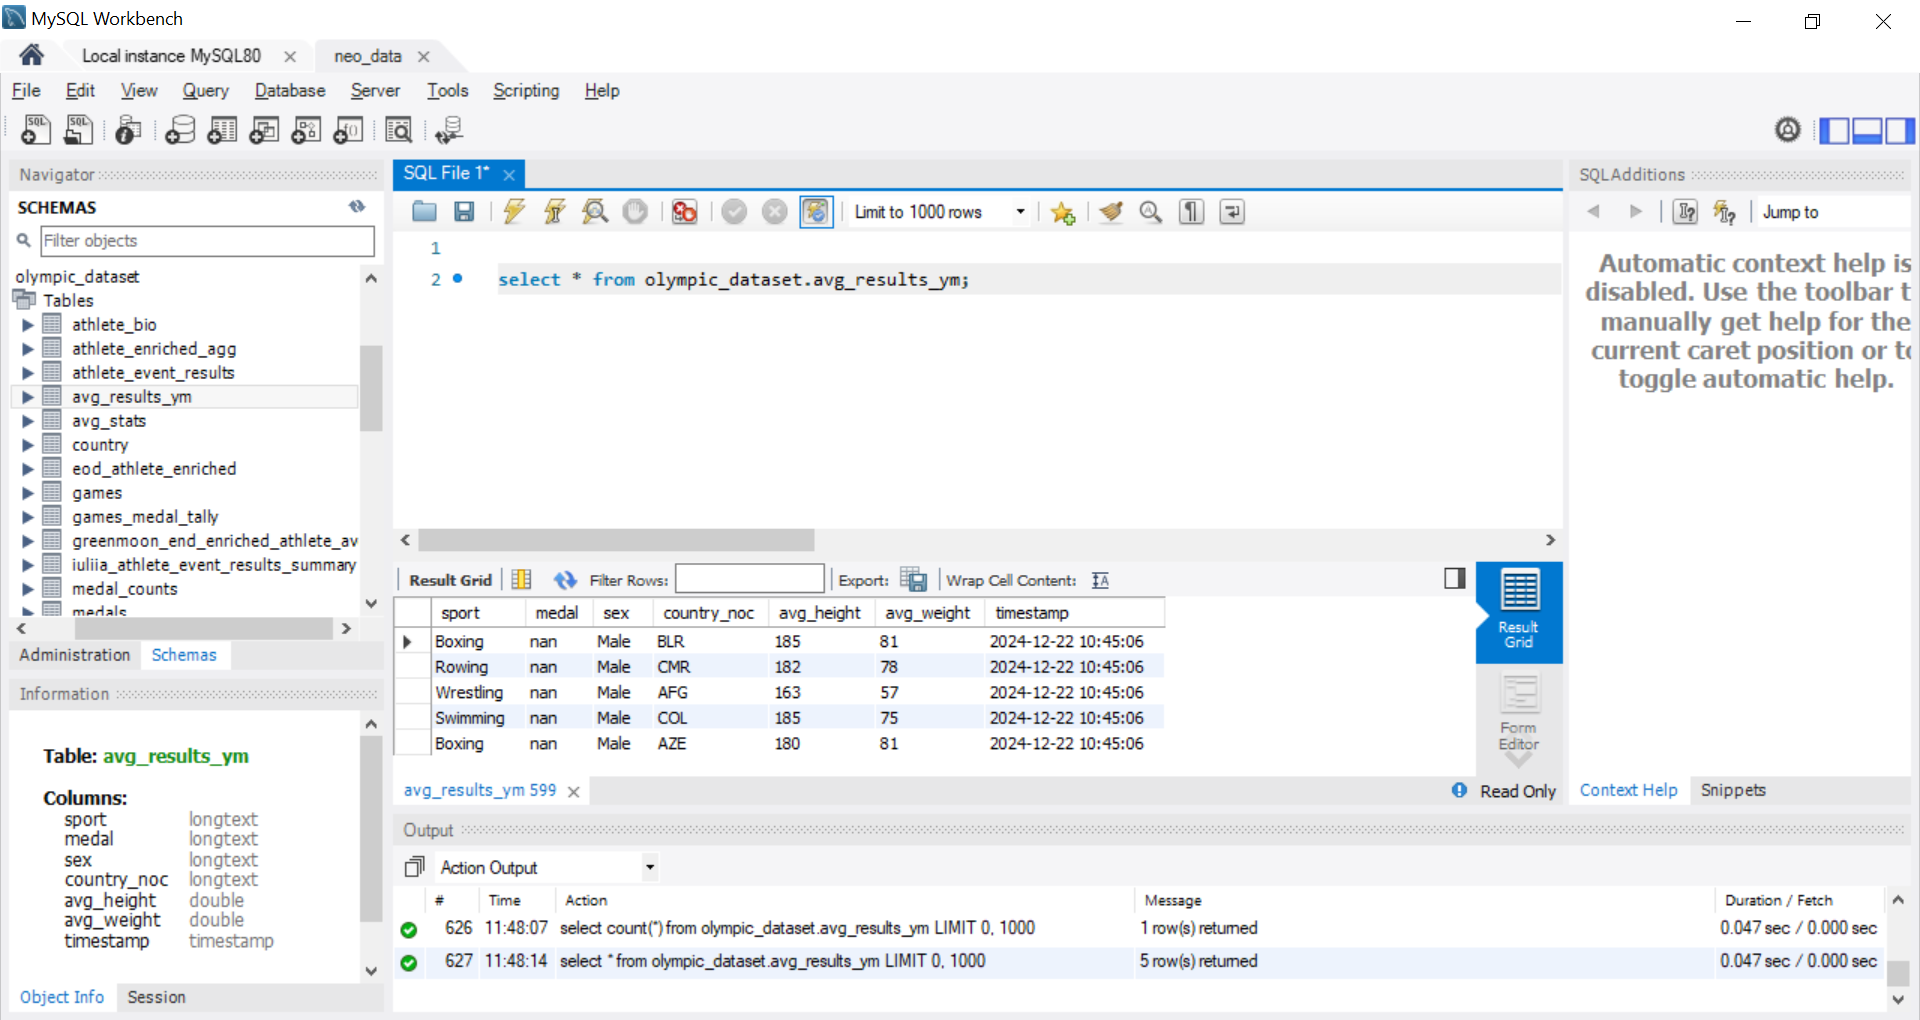